In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import librosa.display as lrdisplay
import librosa.feature as lrfeature
import glob

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as skmetrics

import vxs
import vxs.utils as vxsu

In [2]:
avp_segments_fixed = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/fixed/*/*.wav'))
print(len(avp_segments_fixed))
avp_segments_personal = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))
print(len(avp_segments_personal))
bbset1_segments = vxs.SimpleSampleSet(glob.glob('../data_temp/beatboxset1/DR/*/*.wav'))
print(len(bbset1_segments))
drums200 = vxs.SimpleSampleSet.from_csv('../data/200-drum-machines/annotation.csv')
print(len(drums200))

3316
2875
2317
1422


### Classifying segments using only synth drum samples data

In [6]:
def mk_model(mtype, **kwargs):
    if mtype == 'mfcc':
        return vxs.make_knn_classic('mfcc', **kwargs)
    elif mtype == 'ramires':
        return vxs.make_knn_classic('ramires', **kwargs)
    else:
        nn = vxs.get_CAE_model(mtype, f'../logs/cae-initial_65536_{mtype}/checkpoints/best.pth')
        return vxs.make_knn_cae(nn.encoder, **kwargs)
    
def train_test_model(model, train_data, test_data):
    model.fit(train_data.tracks, train_data.classes)
    y_pred = model.predict(test_data.tracks)
    cf = skmetrics.confusion_matrix(test_data.classes, y_pred)
    acc = skmetrics.accuracy_score(test_data.classes, y_pred)
    return cf, acc

In [7]:
models = {mtype: mk_model(mtype, n_neighbors=15, weights='distance')
          for mtype in ['mfcc', 'ramires', 'square-1', 'tall-4', 'wide-4']}

In [8]:
for mtype, model in models.items():
    print('model ' + mtype)
    cf, acc = train_test_model(model, drums200, bbset1_segments)
    print(cf)
    print(acc)

model mfcc
[[  9   0 653 220]
 [  0   0  43  62]
 [  0   0 580  47]
 [  0   0 243 460]]
0.4527406128614588
model ramires
[[ 65   5 223 589]
 [ 11   0   7  87]
 [  0   0 585  42]
 [  2   5 210 486]]
0.49028916702632713
model square-1
[[ 11  43 576 252]
 [  1   6  19  79]
 [  0   0 539  88]
 [  0   0 201 502]]
0.4566249460509279
model tall-4
[[ 17   3 673 189]
 [  1   0  14  90]
 [  0   0 597  30]
 [  0   0 259 444]]
0.4566249460509279
model wide-4
[[ 41  24 616 201]
 [  5   8  18  74]
 [  0   0 594  33]
 [  0   0 239 464]]
0.4777729823047044


In [17]:
models['wide-4'].classes_

array(['hhc', 'hho', 'kd', 'sd'], dtype='<U3')

### Classifying AVP segments

In [9]:
X_test, y_test = vxsu.unzip_dataset(avp_segments_personal)

In [10]:
model_mfcc = vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance')
model_mfcc.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [18]:
for k in [3, 5, 7, 10, 15]:
    model = model_mfcc.set_params(knn__n_neighbors=k)
    y_pred = model.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, y_pred)
    print(f'{k} neighbors: {acc}')

3 neighbors: 0.5501043841336117
5 neighbors: 0.5494084899095337
7 neighbors: 0.5448851774530271
10 neighbors: 0.5480167014613778
15 neighbors: 0.5556715379262352


In [19]:
model_mfcc.set_params(knn__weights='distance')
for k in [3, 5, 7, 10, 15]:
    model = model_mfcc.set_params(knn__n_neighbors=k)
    y_pred = model.predict(X_test)
    acc = skmetrics.accuracy_score(y_test, y_pred)
    print(f'{k} neighbors: {acc}')

3 neighbors: 0.5438413361169102
5 neighbors: 0.5490605427974948
7 neighbors: 0.545929018789144
10 neighbors: 0.5504523312456506
15 neighbors: 0.5549756437021572


In [11]:
y_pred = model_mfcc.predict(X_test)

In [12]:
skmetrics.confusion_matrix(y_test, y_pred)

array([[518,  90,  29,  75],
       [350, 273,  31,  72],
       [ 73,  35, 521,  81],
       [194, 217,  32, 283]])

In [13]:
skmetrics.accuracy_score(y_test, y_pred)

0.5549756437021572

### Ramires features

In [21]:
model_ramires = vxs.make_knn_classic('ramires')
model_ramires.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransformer(feature_type='ramires')),
                ('normalizer', Normalizer()), ('knn', KNeighborsClassifier())])

In [22]:
y_pred2 = model_ramires.predict(X_test)

In [23]:
skmetrics.confusion_matrix(y_test, y_pred2)

array([[534, 243,  99, 159],
       [402, 343,  66,  87],
       [240,  45, 726, 262],
       [403, 336,  52, 309]])

In [24]:
skmetrics.accuracy_score(y_test, y_pred2)

0.4440315838365072

### Autoencoder features

In [97]:
model = vxs.get_CAE_model('square-1', '../logs/cae-initial_65536_square-1/checkpoints/best.pth')
encoder = model.encoder
encoder.eval()
model_cae = vxs.make_knn_cae(encoder)

In [98]:
model_cae.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn', KNeighborsClassifier())])

In [99]:
y_pred3 = model_cae.predict(X_test)

In [30]:
skmetrics.confusion_matrix(y_test, y_pred3)

array([[ 697,  159,   81,   98],
       [ 366,  397,   48,   87],
       [ 130,   25, 1004,  114],
       [ 278,  328,  121,  373]])

In [31]:
skmetrics.accuracy_score(y_test, y_pred3)

0.5738504412447747

In [47]:
model_wide = vxs.get_CAE_model('wide-4', '../logs/cae-initial_65536_wide-4/checkpoints/best.pth')
model_wide.eval()
model_cae_wide = vxs.make_knn_cae(model_wide.encoder)

In [48]:
model_cae_wide.fit(X, y)

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(2, 2), padding=(1, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn', KNeighborsClassifier())])

In [34]:
y_pred4 = model_cae_wide.predict(X_test)

In [35]:
skmetrics.confusion_matrix(y_test, y_pred4)

array([[673, 186,  68, 108],
       [348, 412,  50,  88],
       [138,  17, 956, 162],
       [285, 295,  85, 435]])

In [36]:
skmetrics.accuracy_score(y_test, y_pred4)

0.5750116117045982

In [37]:
ftfm = model_cae_wide.named_steps['cae_features']
ftfm.transform(X[:5])[0].shape

(32,)

In [38]:
ftfm_big = model_cae.named_steps['cae_features']
ftfm_big.transform(X[:5])[0].shape

(256,)

### Segmentation + classification

In [14]:
avp_fixed_improvs = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Fixed', recordings_type='improvs')
len(avp_fixed_improvs)

28

In [15]:
track_10, anno_10 = avp_fixed_improvs.get('P10_Improvisation_Fixed')

In [16]:
lang_model = vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmp5f8i4wqt/model_drum_kit.ckpt


In [17]:
analysis_result_nolang = vxs.segment_classify(track_10, model_mfcc)
analysis_result_lang = vxs.segment_classify(track_10, model_mfcc, lang_model)

INFO:tensorflow:Beam search yields sequence with log-likelihood: -149.455436 


In [18]:
import note_seq
note_seq.plot_sequence(analysis_result_lang['note_seq'])

Loading BokehJS ...

In [19]:
resulting_sound = vxs.Track(note_seq.fluidsynth(analysis_result_lang['note_seq'], sample_rate=44100))

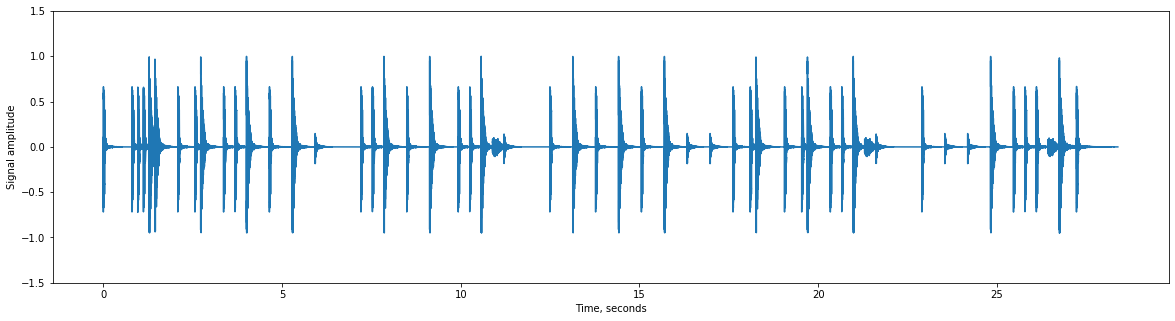

In [20]:
vxsu.plot_track(resulting_sound)

In [21]:
vxsu.play_audio(resulting_sound)

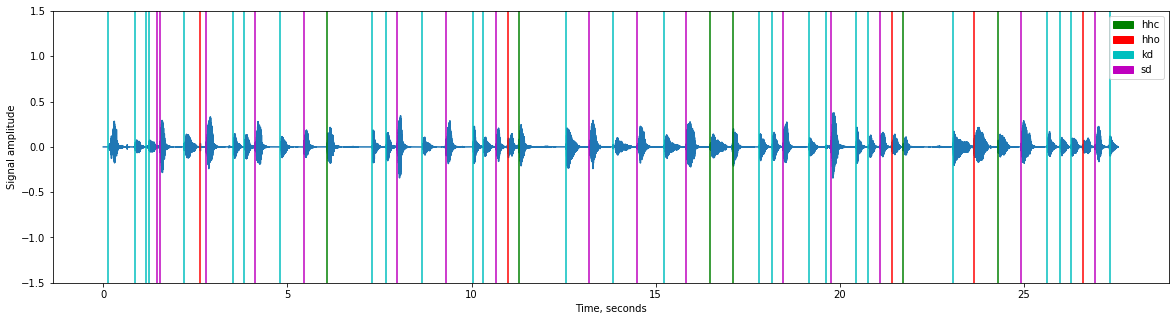

In [22]:
vxsu.plot_track(track_10, analysis_result_nolang['onsets'], color_events=True)

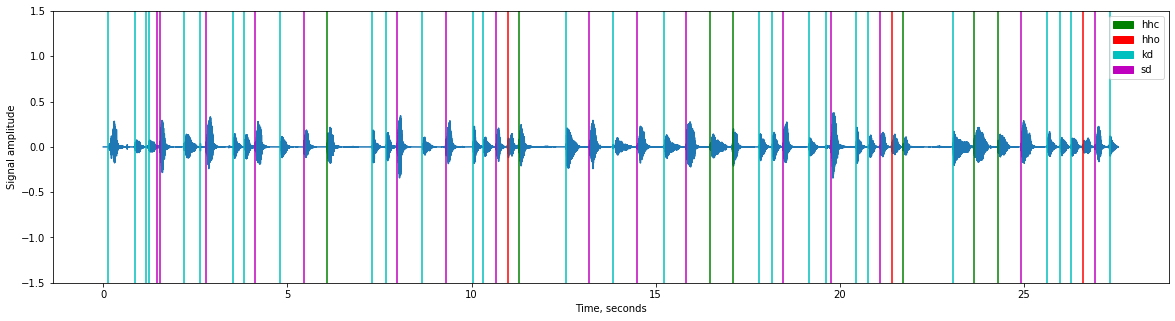

In [23]:
vxsu.plot_track(track_10, analysis_result_lang['onsets'], color_events=True)

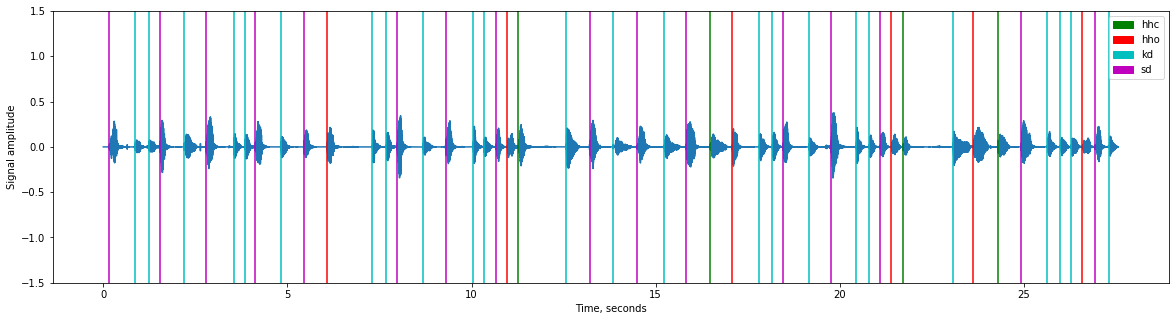

In [24]:
vxsu.plot_track(track_10, anno_10, color_events=True)

In [25]:
vxs.classes_F1_score(analysis_result_nolang['onsets'], anno_10, ms_threshold=50)

,hhc,hho,kd,sd,sil
hhc,4,0,0,0,0
hho,2,4,0,0,0
kd,0,0,24,0,0
sd,0,0,1,15,0
sil,0,1,2,1,0


In [26]:
vxs.classes_F1_score(analysis_result_lang['onsets'], anno_10, ms_threshold=50)

,hhc,hho,kd,sd,sil
hhc,4,0,0,0,0
hho,3,3,0,0,0
kd,0,0,24,0,0
sd,0,0,1,15,0
sil,0,0,3,1,0


In [28]:
%%time
mfcc_cf, mfcc_scores = vxs.segment_classify_all(avp_fixed_improvs, model_mfcc,
                                                quantization_conflict_resolution=None)

Analysing tracks: 28it [00:19,  1.41it/s]

CPU times: user 27.7 s, sys: 1min 43s, total: 2min 11s
Wall time: 19.8 s


In [29]:
mfcc_cf

,hhc,hho,kd,sd,sil
hhc,252.0,17.0,7.0,12.0,20.0
hho,81.0,281.0,0.0,0.0,4.0
kd,9.0,3.0,482.0,20.0,32.0
sd,17.0,2.0,4.0,331.0,11.0
sil,33.0,24.0,50.0,23.0,0.0


In [30]:
mfcc_scores

,prec,rec,F1
hhc,0.642857,0.818182,0.72
hho,0.859327,0.76776,0.810967
kd,0.887661,0.882784,0.885216
sd,0.857513,0.906849,0.881491


In [31]:
mfcc_scores.mean()

prec    0.811840
rec     0.843894
F1      0.824418
dtype: float64

In [43]:
%%time
mfcc_lm_cf, mfcc_lm_scores = vxs.segme4nt_classify_all(avp_fixed_improvs, model_mfcc, lang_model,
                                                      steps_per_iteration=4, beam_size=5)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -149.992868 


Analysing tracks: 1it [00:03,  3.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -266.625396 


Analysing tracks: 2it [00:08,  4.00s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -207.851083 


Analysing tracks: 3it [00:12,  4.11s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -124.028153 


Analysing tracks: 4it [00:15,  3.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -156.097057 


Analysing tracks: 5it [00:19,  3.62s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -209.455574 


Analysing tracks: 6it [00:23,  3.90s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -232.519416 


Analysing tracks: 7it [00:29,  4.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -110.669639 


Analysing tracks: 8it [00:33,  4.25s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -111.834989 


Analysing tracks: 9it [00:35,  3.61s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -311.530972 


Analysing tracks: 10it [00:42,  4.65s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -104.986949 


Analysing tracks: 11it [00:44,  3.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -132.615465 


Analysing tracks: 12it [00:47,  3.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -157.346186 


Analysing tracks: 13it [00:50,  3.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -167.543406 


Analysing tracks: 14it [00:54,  3.43s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -124.978110 


Analysing tracks: 15it [00:56,  3.09s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -357.800713 


Analysing tracks: 16it [01:05,  5.05s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -176.333400 


Analysing tracks: 17it [01:10,  4.76s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.550439 


Analysing tracks: 18it [01:12,  4.13s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -350.624477 


Analysing tracks: 19it [01:19,  4.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -86.811959 


Analysing tracks: 20it [01:21,  4.07s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -127.259351 


Analysing tracks: 21it [01:23,  3.57s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -91.359554 


Analysing tracks: 22it [01:25,  3.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -83.459721 


Analysing tracks: 23it [01:27,  2.74s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.451721 


Analysing tracks: 24it [01:29,  2.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -94.711989 


Analysing tracks: 25it [01:31,  2.37s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -166.945400 


Analysing tracks: 26it [01:35,  2.84s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -246.479915 


Analysing tracks: 27it [01:42,  4.13s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -122.893853 


Analysing tracks: 28it [01:45,  3.76s/it]

CPU times: user 2min 8s, sys: 1min 42s, total: 3min 50s
Wall time: 1min 45s


In [44]:
mfcc_lm_cf

,hhc,hho,kd,sd,sil
hhc,240.0,19.0,3.0,20.0,26.0
hho,140.0,214.0,0.0,3.0,9.0
kd,12.0,1.0,469.0,20.0,44.0
sd,14.0,0.0,20.0,319.0,12.0
sil,24.0,15.0,54.0,28.0,0.0


In [45]:
mfcc_lm_scores

,prec,rec,F1
hhc,0.55814,0.779221,0.650407
hho,0.859438,0.584699,0.695935
kd,0.858974,0.858974,0.858974
sd,0.817949,0.873973,0.845033


In [46]:
mfcc_lm_scores.mean()

prec    0.773625
rec     0.774217
F1      0.762587
dtype: float64

In [115]:
model_cae_wide.set_params(knn__weights='distance')
model_cae_wide.set_params(knn__n_neighbors=15)
model_cae_wide

Pipeline(steps=[('cae_features',
                 CAEFeatureTransform(encoder=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 5), stride=(2, 2), padding=(1, 2))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(8, 16, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac...
  (6): Conv2d(16, 24, kernel_size=(9, 9), stride=(4, 2), padding=(4, 4))
  (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(24, 32, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
))),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [49]:
%%time
cwide_cf, cwide_scores = vxs.segment_classify_all(avp_fixed_improvs, model_cae_wide,
                                                  quantization_conflict_resolution=None)

Analysing tracks: 28it [00:46,  1.65s/it]

CPU times: user 2min 20s, sys: 3min 18s, total: 5min 38s
Wall time: 46.2 s


In [50]:
cwide_cf

,hhc,hho,kd,sd,sil
hhc,237.0,12.0,13.0,26.0,20.0
hho,150.0,212.0,0.0,0.0,4.0
kd,14.0,0.0,447.0,53.0,32.0
sd,24.0,5.0,64.0,261.0,11.0
sil,19.0,23.0,58.0,30.0,0.0


In [51]:
cwide_scores

,prec,rec,F1
hhc,0.533784,0.769481,0.630319
hho,0.84127,0.579235,0.686084
kd,0.768041,0.818681,0.792553
sd,0.705405,0.715068,0.710204


In [52]:
cwide_scores.mean()

prec    0.712125
rec     0.720616
F1      0.704790
dtype: float64

In [53]:
%%time
cwide_lm_cf, cwide_lm_scores = vxs.segment_classify_all(avp_fixed_improvs, model_cae_wide, lang_model,
                                                        steps_per_iteration=4, beam_size=5)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -148.311318 


Analysing tracks: 1it [00:05,  5.26s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -255.702624 


Analysing tracks: 2it [00:11,  5.59s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -221.255178 


Analysing tracks: 3it [00:17,  5.63s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -126.551259 


Analysing tracks: 4it [00:20,  4.90s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -151.994975 


Analysing tracks: 5it [00:24,  4.70s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -212.526894 


Analysing tracks: 6it [00:30,  5.03s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -214.113788 


Analysing tracks: 7it [00:36,  5.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -150.562102 


Analysing tracks: 8it [00:40,  4.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.597914 


Analysing tracks: 9it [00:44,  4.49s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -316.136037 


Analysing tracks: 10it [00:53,  5.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -129.569840 


Analysing tracks: 11it [00:56,  5.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -130.501677 


Analysing tracks: 12it [01:01,  4.95s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -158.264004 


Analysing tracks: 13it [01:05,  4.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -158.903973 


Analysing tracks: 14it [01:10,  4.73s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -130.951975 


Analysing tracks: 15it [01:13,  4.22s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -336.499228 


Analysing tracks: 16it [01:23,  5.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -155.482763 


Analysing tracks: 17it [01:27,  5.47s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -98.534932 


Analysing tracks: 18it [01:31,  4.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -348.652083 


Analysing tracks: 19it [01:40,  6.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -95.859671 


Analysing tracks: 20it [01:43,  5.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -136.104650 


Analysing tracks: 21it [01:47,  5.01s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -100.015798 


Analysing tracks: 22it [01:51,  4.53s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -84.581556 


Analysing tracks: 23it [01:54,  4.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -88.758473 


Analysing tracks: 24it [01:57,  3.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -93.704565 


Analysing tracks: 25it [01:59,  3.32s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -179.412687 


Analysing tracks: 26it [02:04,  3.78s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -237.752522 


Analysing tracks: 27it [02:12,  5.11s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.957232 


Analysing tracks: 28it [02:16,  4.87s/it]

CPU times: user 4min 13s, sys: 3min 30s, total: 7min 43s
Wall time: 2min 16s


In [56]:
cwide_lm_cf

,hhc,hho,kd,sd,sil
hhc,236.0,8.0,12.0,26.0,26.0
hho,181.0,172.0,0.0,4.0,9.0
kd,6.0,0.0,403.0,93.0,44.0
sd,21.0,6.0,73.0,253.0,12.0
sil,19.0,18.0,52.0,32.0,0.0


In [57]:
cwide_lm_scores

,prec,rec,F1
hhc,0.509719,0.766234,0.612192
hho,0.843137,0.469945,0.603509
kd,0.746296,0.738095,0.742173
sd,0.620098,0.693151,0.654592


In [58]:
cwide_lm_scores.mean()

prec    0.679813
rec     0.666856
F1      0.653117
dtype: float64